In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#pd.set_option("display.max_rows", 1000)
pd.set_option("display.max_columns", 100)

In [3]:
file_paths = {'in':'../../../data/prepared/activity_log_prepared.csv',
              'out':'../../../data/prepared/activity_log_prepared.csv'
             }

df = pd.read_csv(file_paths['in'])

# guarantee the timestamps are datetime objects
time_columns = ['start_time','end_time']

for time_col in time_columns:
    df[time_col] = pd.to_datetime(df[time_col])

In [4]:
df.head()

,start_time,ride_id,row_count,segment_count,end_time,elapsed_time,moving_time,elapsed_distance,elapsed_ascent,elapsed_descent,max_speed,avg_speed,ride_cruise_speed,avg_power,ride_avg_power,ride_max_power,peak_20min_power,training_window_id,perceived_exertion,simple_exertion,perceived_relative_effort,ride_work,hours_since_last_ride,active_time_ratio,ftp_power,intensity,time_intensity
0,2020-01-02 14:02:58+00:00,2975587283,1352,5,2020-01-02 14:29:32+00:00,1642,1411,5.266647,137.1458,138.7863,20.132460,14.045509,14.547075,NaN,116.870855,5.520265e+02,124.782357,0,7.0,HARD,45.0,191.901944,10000.000000,0.859318,131.178797,0.890928,NaN
1,2020-01-08 13:20:26+00:00,2992935347,1426,5,2020-01-08 13:49:06+00:00,1728,1472,5.167961,215.2336,153.2227,31.764548,13.119808,14.154069,NaN,122.304555,9.702958e+02,131.178797,0,NaN,NaN,NaN,211.342270,142.848333,0.851852,131.178797,0.932350,75.544039
2,2020-01-08 22:08:17+00:00,2994399692,1423,7,2020-01-08 22:35:04+00:00,1608,1481,5.257609,158.4723,219.4989,25.501115,13.339800,15.443823,NaN,113.161863,1.299650e+03,126.461932,0,NaN,NaN,NaN,181.964276,8.319722,0.921020,131.178797,0.862654,4.305494
3,2020-04-02 21:38:02+00:00,3248077156,2580,5,2020-04-02 23:03:45+00:00,5143,2544,6.759676,329.4124,274.6197,29.974995,9.548413,13.495738,NaN,100.591028,2.608934e+05,NaN,1,5.0,NORMAL,45.0,517.339656,2039.049444,0.494653,134.266490,0.749189,1094.701363
4,2020-04-04 17:23:43+00:00,3255473930,6416,12,2020-04-04 19:59:16+00:00,9348,6356,22.730090,575.1593,576.4717,32.211935,12.764180,14.009717,NaN,100.591028,3.328601e+06,121.068376,1,5.0,NORMAL,114.0,940.324927,42.332778,0.679932,134.266490,0.749189,24.201369


In [4]:
df.shape

(218, 22)

# Time Since Last Ride

In [10]:
# ensure that the data is sorted chronologically
df = df.set_index('start_time').sort_index().reset_index()

In [15]:
# create a temporary column for the Last end time in UTC seconds
df['last_ride_end'] = df['end_time'].apply(lambda x: x.timestamp()).shift()

In [18]:
sec2hour = 1.0/3600 # convert seconds to hours
df['hours_since_last_ride'] = sec2hour*(df['start_time'].apply(lambda x: x.timestamp()) - df['last_ride_end'])

In [22]:
df['hours_since_last_ride'] = df['hours_since_last_ride'].fillna(10000) # assume any contribution to fatigue/fitness is 0 ...
df['hours_since_last_ride'].head(10)

0    10000.000000
1      142.848333
2        8.319722
3     2039.049444
4       42.332778
5      169.151111
6       16.069722
7       25.643611
8       26.543611
9       46.363889
Name: hours_since_last_ride, dtype: float64

In [23]:
df.drop(['last_ride_end'], axis=1, inplace=True) # drop temporary column

# Active Time Ratio

In [24]:
df['active_time_ratio'] = df['moving_time'] / df['elapsed_time']

# FTP Calculation & Intensity

### FTP Calculation and Cleaning

In [35]:
ftp_cols = ['training_window_id','peak_20min_power']
df[ftp_cols].groupby('training_window_id').max()

,peak_20min_power
training_window_id,
0,131.178797
1,134.266490
2,150.497627
3,161.323024
4,146.082425
5,144.460600
6,155.238673
7,153.464051
8,150.159838


In [30]:
df[ftp_cols].describe()

,training_window_id,peak_20min_power
count,218.000000,186.000000
mean,5.573394,2151.790733
std,3.327947,22610.432217
min,0.000000,34.464474
25%,3.000000,106.434848
50%,5.000000,128.536546
75%,9.000000,144.037048
max,12.000000,302729.659500


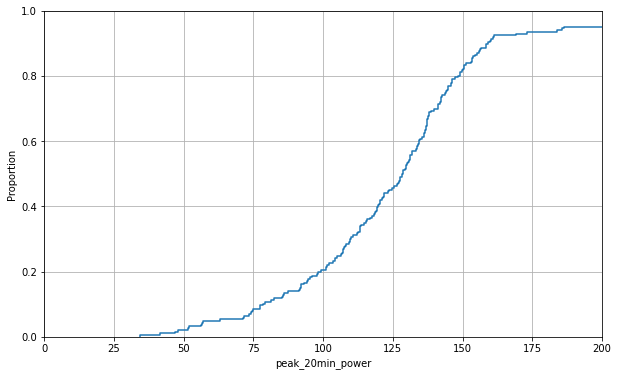

In [33]:
fig = plt.figure(figsize=(10,6))

_ = sns.ecdfplot(data=df, x='peak_20min_power')
_ = plt.grid()
_ = plt.xlim([0,200])

# A 170 Watt threshold would like work here

In [34]:
# replace outlier peak powers with null
filt_peak_power_outlier = df['peak_20min_power']  >= 170
df.loc[filt_peak_power_outlier, 'peak_20min_power'] = np.nan

In [37]:
df_ftp = df[ftp_cols].groupby('training_window_id').max().rename(columns={'peak_20min_power':'ftp_power'})
df_ftp

,ftp_power
training_window_id,
0,131.178797
1,134.266490
2,150.497627
3,161.323024
4,146.082425
5,144.460600
6,155.238673
7,153.464051
8,150.159838


In [39]:
df = df.merge(df_ftp, on='training_window_id')

### Intensity Calculation

In [40]:
df['intensity'] = df['ride_avg_power'] / df['ftp_power']

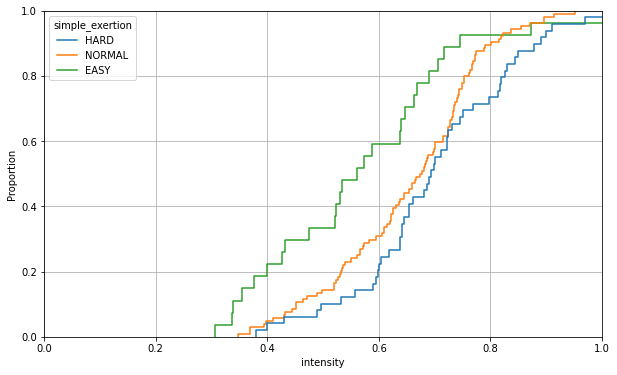

In [42]:
fig = plt.figure(figsize=(10,6))

_ = sns.ecdfplot(data=df, x='intensity', hue='simple_exertion')
_ = plt.grid()
_ = plt.xlim([0,1])

# A 170 Watt threshold would like work here

# Time-Intensity Quotient

A ride that happens 10 hours ago is more fatiguing if it was high intensity. As such, we want to increase the "fatigue variable" using the following formula:

$\text{time_intensity} = \frac{\text{hours since last ride}}{1+\text{(Intensity of last ride)}}$

That way, a fully intense (1.0) previous ride will halve the effective hours since last ride

In [44]:
df['time_intensity'] = df['hours_since_last_ride'] / (1 + df['intensity'].shift())

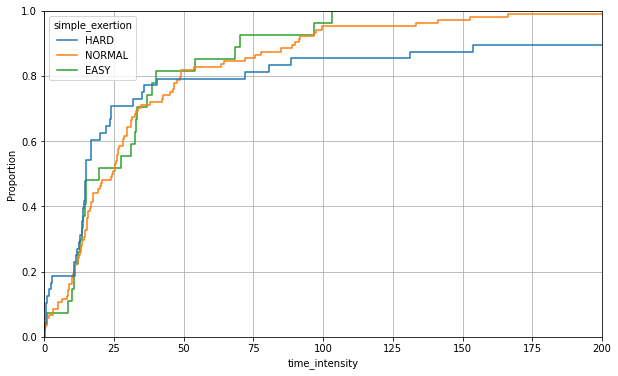

In [49]:
fig = plt.figure(figsize=(10,6))

_ = sns.ecdfplot(data=df, x='time_intensity', hue='simple_exertion')
_ = plt.grid()
_ = plt.xlim([0,200])

# A 170 Watt threshold would like work here

# Ride Time of Day and Day of Week

In [8]:
df['start_TOD'] = df['start_time'].apply(lambda x: x.hour)

In [9]:
df['start_DOW'] = df['start_time'].apply(lambda x: x.dayofweek)

In [12]:
df['time_intensity'] = df['time_intensity'].fillna(10000)

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 218 entries, 0 to 217
Data columns (total 29 columns):
 #   Column                     Non-Null Count  Dtype              
---  ------                     --------------  -----              
 0   start_time                 218 non-null    datetime64[ns, UTC]
 1   ride_id                    218 non-null    int64              
 2   row_count                  218 non-null    int64              
 3   segment_count              218 non-null    int64              
 4   end_time                   218 non-null    datetime64[ns, UTC]
 5   elapsed_time               218 non-null    int64              
 6   moving_time                218 non-null    int64              
 7   elapsed_distance           218 non-null    float64            
 8   elapsed_ascent             218 non-null    float64            
 9   elapsed_descent            218 non-null    float64            
 10  max_speed                  218 non-null    float64            
 11  avg_sp

In [14]:
df.to_csv(file_paths['out'], index=False)